## Exploratory Data Analysis on PPEP Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pandas.tools.plotting import scatter_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from __future__ import division

In [2]:
def data_cleaning_function(filepath):
    '''
    load data into a pandas dataframe from the csv file
    '''
    df_ = pd.read_csv(filepath)
    '''
    Drop the last five columns which were non user data generated when downloading
    data from Salesforce
    '''
    df_ = df_.ix[:3570,:]

    '''
    keep only the data that has DOC numbers
    '''
    df_.dropna(subset =['DOC / Agency #'], inplace= True)

    '''
    create a count of recidivism events for each person
    '''
    recidivism_events = df_.groupby('DOC / Agency #').count()['Recidivism Event Name']
    df_ = df_.drop_duplicates('DOC / Agency #')
    df_.set_index('DOC / Agency #', inplace = True)

    '''
    concat the recidivism count with original data frame
    '''
    clean_df = pd.concat([df_, recidivism_events], axis = 1)

    '''
    rename the columns
    '''
    clean_df.columns= ['full_name', 'recidivism_event_name', 's_code',
           'level_of_service', 'education_level_when_released',
           'gender', 'race_or_ethnicity', 'num_of_children',
           'num_recidivisms']
    '''
    create ordinal values for the education column
    '''
    clean_df['education_level_when_released'] = clean_df['education_level_when_released'].map({'nan': 0,\
        'Passed 8th Grade': 0,'Passed 8th Grade': 1,'GED': 2, 'High School Diploma': 3, 'Some College': 4,\
        'Associates Degree': 5, 'Bachelors Degree': 6})
    return clean_df

clean_df = data_cleaning_function('data/data_with_agencynum.csv')

In [3]:
clean_df.columns

Index(['full_name', 'recidivism_event_name', 's_code', 'level_of_service',
       'education_level_when_released', 'gender', 'race_or_ethnicity',
       'num_of_children', 'num_recidivisms'],
      dtype='object')

In [ ]:
clean_df.head()

In [ ]:
clean_df.tail()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb378315e80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb37517dac8>]], dtype=object)

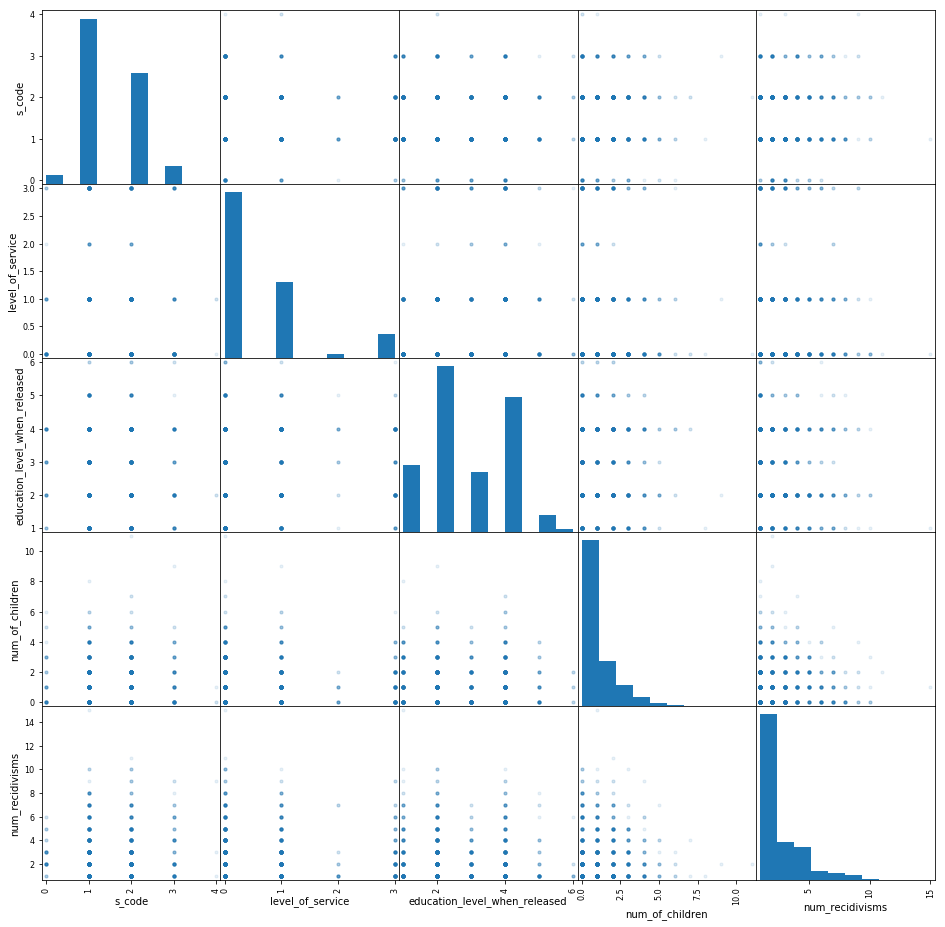

In [4]:
scatter_matrix(clean_df, figsize = (16,16), alpha=0.1)

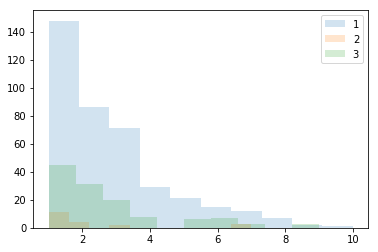

In [5]:
fig, ax = plt.subplots()
for los in range(1,4):
    ax.hist(clean_df[clean_df.level_of_service==los].num_recidivisms, alpha=0.2, label=str(los))
ax.legend()

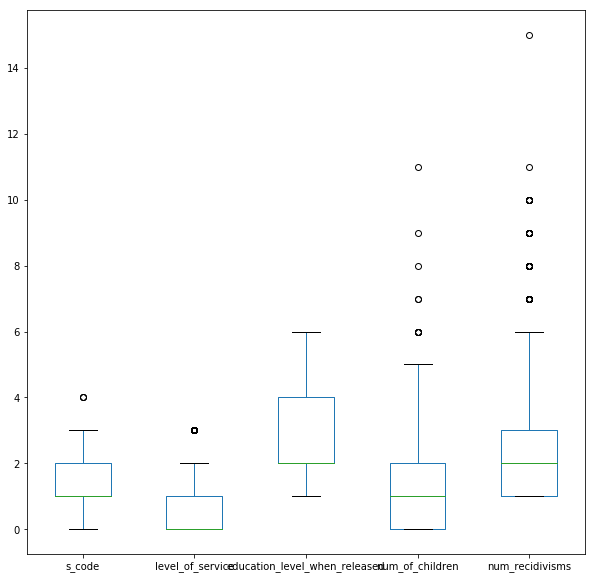

In [6]:
clean_df.plot(kind='box', figsize=(10,10))

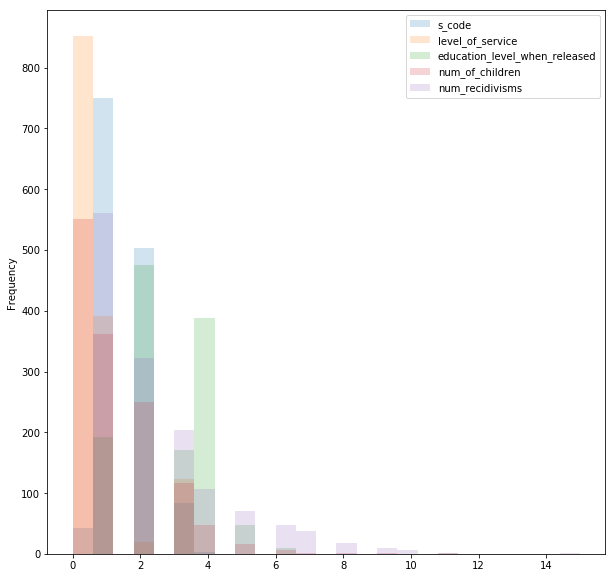

In [7]:
clean_df.plot(bins=25, alpha=0.2, kind='hist', figsize = (10,10))

In [8]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1387 entries, 127649.0 to 998969.0
Data columns (total 9 columns):
full_name                        1387 non-null object
recidivism_event_name            1387 non-null object
s_code                           1383 non-null float64
level_of_service                 1387 non-null float64
education_level_when_released    1283 non-null float64
gender                           1342 non-null object
race_or_ethnicity                1246 non-null object
num_of_children                  1352 non-null float64
num_recidivisms                  1387 non-null int64
dtypes: float64(4), int64(1), object(4)
memory usage: 108.4+ KB


In [9]:
clean_df.describe()

,s_code,level_of_service,education_level_when_released,num_of_children,num_recidivisms
count,1383.000000,1387.000000,1283.000000,1352.000000,1387.000000
mean,1.460593,0.577505,2.728761,1.151627,2.505407
std,0.667415,0.897495,1.188087,1.320542,1.896056
min,0.000000,0.000000,1.000000,0.000000,1.000000
25%,1.000000,0.000000,2.000000,0.000000,1.000000
50%,1.000000,0.000000,2.000000,1.000000,2.000000
75%,2.000000,1.000000,4.000000,2.000000,3.000000
max,4.000000,3.000000,6.000000,11.000000,15.000000


In [10]:
dummies = pd.get_dummies(clean_df, columns =['education_level_when_released', 'race_or_ethnicity', 'gender' ])

In [11]:
dummies.drop(['full_name', 'recidivism_event_name'], inplace = True, axis = 1)
x = dummies.dropna(axis = 0)

In [12]:
ppep_clients = x[x.level_of_service == 3]
ppep_y  = ppep_clients['num_recidivisms'] > 1
ppep_clients.drop('num_recidivisms', inplace = True, axis = 1)

/home/rnjeri/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [13]:
non_ppep_clients = x[x.level_of_service == 3]
non_ppep_y  = non_ppep_clients['num_recidivisms'] > 1
non_ppep_clients.drop('num_recidivisms', inplace = True, axis = 1)

/home/rnjeri/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [ ]:
y  = x['num_recidivisms'] > 1
x.drop('num_recidivisms', inplace = True, axis = 1)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [17]:
x_train,x_test, y_train, y_test = train_test_split(x,y)

In [18]:
ppepx_train, ppepx_test, ppepy_train, ppepy_test = train_test_split(ppep_clients, ppep_y)

In [19]:
nonppepx_train, nonppepx_test, nonppepy_train, nonppepy_test = train_test_split(non_ppep_clients, non_ppep_y)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [21]:
gbc = GradientBoostingClassifier()
gbc_model_ = gbc.fit(x_train, y_train)
print (gbc_model_.score(x_test, y_test))

0.643916913947


In [22]:
gbc = GradientBoostingClassifier()
gbc_model_a = gbc.fit(ppepx_train, ppepy_train)
print (gbc_model_a.score(ppepx_test,ppepy_test))

0.448275862069


In [23]:
gbc = GradientBoostingClassifier()
gbc_model_b = gbc.fit(nonppepx_train, nonppepy_train)
print (gbc_model_b.score(nonppepx_test, nonppepy_test))

0.689655172414


In [24]:
rfc = RandomForestClassifier()
rfc_model = rfc.fit(x_train, y_train)
print (rfc_model.score(x_test, y_test))

0.59940652819


In [25]:
gbc = GradientBoostingClassifier()
gbc_model = gbc.fit(x_train, y_train)
print (gbc_model.score(x_test, y_test))

0.646884272997


In [26]:
clean_df.reset_index(inplace = True)

# Plotting ROC curves

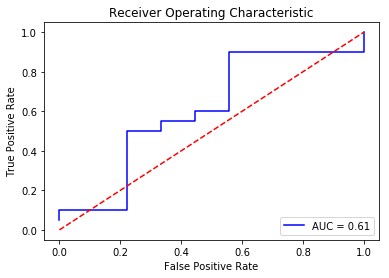

In [27]:
'''
This ROCurve uses the subset of data that contains people who applied to be served
by PPEP but received less than level 3 service
'''
y_predictprob_gbc_b = gbc_model_b.predict_proba(nonppepx_test)
false_positive_rate_gbc_model_b, true_positive_rate_gbc_model_b, thresholds_gdc_model_b = roc_curve(nonppepy_test, y_predictprob_gbc_b[:,1])
roc_auc_gbc_b = auc(false_positive_rate_gbc_model_b, true_positive_rate_gbc_model_b)

##Plot ROC

plt.title('Receiver Operating Characteristic')

plt.plot(false_positive_rate_gbc_model_b, true_positive_rate_gbc_model_b, 'b',
label='AUC = %0.2f'% roc_auc_gbc_b)


plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Comparing AUC for Random Forest and Gradient Boosting Classifiers

In [28]:
##Predicting classification probability for each model 
y_predictprob_rfc = rfc_model.predict_proba(x_test)
y_predictprob_gbc = gbc_model.predict_proba(x_test)

In [29]:
false_positive_rate_rfc, true_positive_rate_rfc, thresholds_rfc = roc_curve(y_test, y_predictprob_rfc[:,1])
false_positive_rate_gbc, true_positive_rate_gbc, thresholds_gbc = roc_curve(y_test, y_predictprob_gbc[:,1])

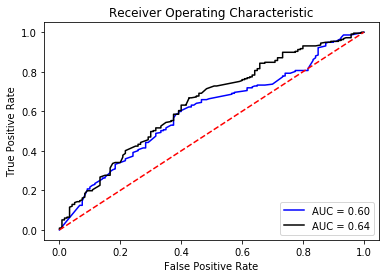

In [30]:
roc_auc_rfc = auc(false_positive_rate_rfc, true_positive_rate_rfc)
roc_auc_gbc = auc(false_positive_rate_gbc, true_positive_rate_gbc)

##Plot ROC

plt.title('Receiver Operating Characteristic')

plt.plot(false_positive_rate_rfc, true_positive_rate_rfc, 'b',
label='AUC = %0.2f'% roc_auc_rfc)

plt.plot(false_positive_rate_gbc, true_positive_rate_gbc, 'k',
label='AUC = %0.2f'% roc_auc_gbc)


plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [31]:
'''
A simulation estimating the aggregate cost of someone recidivating over a three year period
'''
##direct unit cost of incarceration per annum 
unit_cost = 51775
time_period = [1,2,3]

recidivism_probability_within_one_year = 13.7
recidivism_probability_within_two_years = 27.0
recidivism_probability_within_three_years = 34.9

'''
Estimated cost of incarceration while taking into account recidivism rate
'''
cost_if_recidivism_within_one_year = unit_cost * 3 * 0.137
print (0 + unit_cost * 2 * 0.27)
print (0 + 0 + unit_cost * 1 * 0.349)
total_cost = (unit_cost * 3 * 0.137)+ (0 + unit_cost * 2 * 0.27)+(0 + 0 + unit_cost * 1 * 0.349)
print ('Total cost with recidivism: {}'.format(total_cost))



27958.500000000004
18069.475
Total cost with recidivism: 67307.5


In [32]:
unit_cost = 51775
ppep_recidivism_rate = 0.078
general_recidivism_rate = [0.085, 0.12, 0.079]
time_period = [1,2,3]

'''
calculating expected cost of incarceration for a randomly selected person
'''

def general_expected_cost_func():
    expected_cost = 0
    for recidivism_rate in general_recidivism_rate:
        expected_cost += unit_cost * recidivism_rate
    return expected_cost

'''
calculating the expected cost of incarceration with PPEP services
'''
def with_ppep_expected_cost_func():
    expected_cost = 0
    for year in range(3):
        expected_cost += unit_cost * ppep_recidivism_rate
    return expected_cost

print (general_expected_cost_func())
print (with_ppep_expected_cost_func())

14704.1
12115.349999999999


[14393.45, 28786.9, 43180.350000000006]


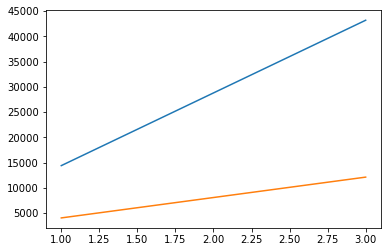

In [33]:
def plot_cost(cost = 51775):
    x = [1,2,3]
    recidivism = 0.278
    ppep_recidivism = 0.078
    y = [i * cost * recidivism for i in x]
    y2 = [i * cost* ppep_recidivism for i in x]
    print (y)
    plt.plot(x,y);
    plt.plot(x, y2)
plot_cost()